# Capstone Project - The Battle of Neighborhoods : *The Districts and Neighbourhoods of Seattle*

## Introduction and Business Problem

The city of Seattle also known as *The Emerald city* is the largest city in the state of Washington and is the inspiration behind Grey's Anatomy's hospital, Seattle Grace / Greys Sloan Memorial Hospital which is set in the city. Seattle, with a  Mediterranean climate is home to the headquarters of the two tech giants, Microsoft and Amazon. The city has a rich culture and up to this day still maintain's its status as a regional centre of the performing arts.

Our project is defined by the following problem. A very famous and fast growing vegan cakes and ice cream restaurant franchise wants to open its doors in the city of Seattle after establishing itself in Europe and some of the vibrant cities in the United States of America. The restaurant is to be opened in a "popular" district with a lot of neighbourhoods that are already well established with lots of restaurants, pubs, movie theaters and etc. The proposed district should be the most popular in the whole city with more than five neighbourhoods.
The franchise is hoping to be provided with a list of these neighbourhoods so that they can make their final decision based on site visits to the various neighbourhoods in one of the districts of Seattle.

## Data Section

We plan to scrape data from the internet (Wikipedia) that includes both the neighbourhoods and their corresponding districts. The raw data might be a bit hard to work with and so we will probably have to clean it and find and replace missing data.
Wikipedia will be our primary source of data for our districts and neighbourhoods and we intend to use **the Foursquare API** to supplement our data and to find the specified venues in the business problem.
We will be using **Geopy** for our location data (latitude/longitude) for the different neighbourhoods and to map our city and neighbourhoods

We import various modules for our implementation

In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



Scraping data from wikipedia of the list of neighbourhoods in Seattle and cleaning our data to make it more usable

In [2]:
page = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle'
scrape = pd.read_html(page, attrs= {"class":"wikitable"})
scrape[0].head()

,Unnamed: 0,Neighborhood name,Within larger district,Annexed[41],Locator map,Street map,Image,Notes
0,1,North Seattle,Seattle,Various,NaN,NaN,NaN,North of the Lake Washington Ship Canal[42]
1,2,Broadview,North Seattle[42],1954[43],NaN,NaN,NaN,[44]
2,3,Bitter Lake,North Seattle[42],1954[43],NaN,NaN,NaN,[45]
3,4,North Beach / Blue Ridge,North Seattle[42],"1940,[43] 1954[43]",NaN,NaN,NaN,[46]
4,5,Crown Hill,North Seattle[42],"1907,[47] 1952,[43] 1954[43]",NaN,NaN,NaN,[48]


In [3]:
seattle = scrape[0]
seattle.drop(columns=['Unnamed: 0','Annexed[41]','Locator map','Street map','Image','Notes'], inplace = True)

In [4]:
seattle.head()

,Neighborhood name,Within larger district
0,North Seattle,Seattle
1,Broadview,North Seattle[42]
2,Bitter Lake,North Seattle[42]
3,North Beach / Blue Ridge,North Seattle[42]
4,Crown Hill,North Seattle[42]


In [5]:
seattle.rename(columns = {'Neighborhood name':'Neighborhood', 'Within larger district':'District'}, inplace = True)

Our data contains reference values from wikipedia and so we will have to correct the names of the districts. Some of the districts have multiple names as some of the regions could be overlapping with other districts and so we will be assigning those with multiple names to the most popular district or to the first name in our values.

In [6]:
seattle['District'].unique()

array(['Seattle', 'North Seattle[42]', 'Northgate[50]', 'Lake City[55]',
       'Windermere[42] / North Seattle',
       'Ravenna[42] / University District',
       'Lake Union / Lower Wallingford, spilling over into Fremont and the University District.',
       'Ballard[78]', 'Central Seattle[42]', 'Magnolia[84]',
       'Queen Anne[89]', 'Capitol Hill[94]',
       'Capitol Hill / Broadway[94]',
       'Capitol Hill[94] / Central Seattle', 'Capitol Hill / Stevens[94]',
       'Capitol Hill / Stevens[94] / Central Seattle', 'Madison Park',
       'North Seattle / Central Seattle', 'Lake Union',
       'South Lake Union', 'Central Seattle', 'Downtown[107]', 'Downtown',
       'Central Area[120]', 'Minor', 'Atlantic', 'Madrona',
       'Harrison/Denny-Blaine', 'South End', 'Rainier Valley[129]',
       'Rainier Valley[129] / Columbia City', 'Seward Park',
       'Beacon Hill[141]', 'Industrial District[147]',
       'West Seattle[151]', 'West Seattle / South End[161]',
       'Delridge[1

In [7]:
districts = pd.DataFrame()
districts['District'] = seattle['District']
districts.head()

,District
0,Seattle
1,North Seattle[42]
2,North Seattle[42]
3,North Seattle[42]
4,North Seattle[42]


In [8]:
districts[districts['District'] == 'North Seattle[42]'] = 'North Seattle'
districts[districts['District']  == 'Northgate[50]'] = 'Northgate'
districts[districts['District']  == 'Lake City[55]'] = 'Lake City'
districts[districts['District']  == 'Windermere[42]'] = 'North Seattle'
districts[districts['District']  == 'Ravenna[42] / University District'] = 'Ravenna'
districts[districts['District']  == 'Lake Union / Lower Wallingford, spilling over into Fremont and the University District.'] = 'Lake Union'
districts[districts['District']  == 'Ballard[78]'] = 'Ballard'
districts[districts['District']  == 'Central Seattle[42]'] = 'Central Seattle'
districts[districts['District']  == 'Magnolia[84]'] = 'Magnolia'
districts[districts['District']  == 'Queen[89]'] = 'Queen'
districts[districts['District']  == 'Capitol Hill / Broadway[94]'] = 'Capitol Hill'
districts[districts['District']  == 'Capitol Hill[94]'] = 'Capitol Hill'
districts[districts['District']  == 'Capitol Hill / Stevens[94]'] = 'Capitol Hill'
districts[districts['District']  == 'North Seattle / Central Seattle'] = 'North Seattle'
districts[districts['District']  == 'Capitol Hill / Stevens[94] / Central Seattle'] = 'Capitol Hill'
districts[districts['District']  == 'Downtown[107]'] = 'Downtown'
districts[districts['District']  == 'Central Area[120]'] = 'Central Area'
districts[districts['District']  == 'Rainier Valley[129]'] = 'Rainer Valley'
districts[districts['District']  == 'Rainier Valley[129] / Columbia City'] = 'Rainer Valley'
districts[districts['District']  == 'Beacon Hill[141]'] = 'Beacon Hill'
districts[districts['District']  == 'Industrial District[147]'] = 'Industrial District'
districts[districts['District']  == 'West Seattle[151]'] = 'West Seattle'
districts[districts['District']  == 'West Seattle / South End[161]'] = 'West Seattle'
districts[districts['District']  == 'Delridge[162]'] = 'Delridge'
districts[districts['District']  == 'Delridge[164]'] = 'Delridge'
districts[districts['District']  == 'Delridge[165]'] = 'Delridge'
districts[districts['District']  == 'Delridge[166]'] = 'Delridge'
districts[districts['District'] == 'Delridge[167]'] = 'Delridge'
districts[districts['District']  == 'Delridge[168]'] = 'Delridge'

In [9]:
districts[districts['District']  == 'Queen Anne[89]'] = 'Queen'
districts[districts['District'] == 'Capitol Hill[94] / Central Seattle'] = 'Capitol Hill'
districts[districts['District'] == 'Windermere[42] / North Seattle'] = 'Windermere'

In [10]:
seattle['District'] = districts['District']

In [11]:
seattle.head()

,Neighborhood,District
0,North Seattle,Seattle
1,Broadview,North Seattle
2,Bitter Lake,North Seattle
3,North Beach / Blue Ridge,North Seattle
4,Crown Hill,North Seattle


Our 'District' column is now clean and we will now proceed in finding the most popular district.

In [12]:
The_Districts = np.unique(seattle['District'].values).tolist()

In [13]:
The_Districts

['Atlantic',
 'Ballard',
 'Beacon Hill',
 'Capitol Hill',
 'Central Area',
 'Central Seattle',
 'Delridge',
 'Downtown',
 'Harrison/Denny-Blaine',
 'Industrial District',
 'Lake City',
 'Lake Union',
 'Madison Park',
 'Madrona',
 'Magnolia',
 'Minor',
 'North Seattle',
 'Northgate',
 'Queen',
 'Rainer Valley',
 'Ravenna',
 'Seattle',
 'Seward Park',
 'South End',
 'South Lake Union',
 'West Seattle',
 'Windermere']

We make a function that will determine our coordinates using geopy. The function will be called at different time in the project and so we run it now. 

In [14]:
def get_lat(address):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(address)
    return location.latitude
def get_long(address):
    geolocator = Nominatim(user_agent="myGeocoder")
    location = geolocator.geocode(address)
    return location.longitude

The **Foursquare API** requires a client ID and other details for the developer API calls and so we run them now so that it will be easier to run them at different times in the project 

In [15]:
CLIENT_ID = 'AF5MWIAHB40CEIS3GNJV2MEYMWAHTSHKFCSGGWVIOYO202HY' 
CLIENT_SECRET = '3R4WONMCEJBSCGOXAUULTSO0CRRZOCNCCCGE3YITXXUSBMBZ'
VERSION = '20200101'

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: AF5MWIAHB40CEIS3GNJV2MEYMWAHTSHKFCSGGWVIOYO202HY
CLIENT_SECRET:3R4WONMCEJBSCGOXAUULTSO0CRRZOCNCCCGE3YITXXUSBMBZ


In [16]:
#we are looking for the most popular spots in Seattle
LIMIT = 100
radius = 500

We look for most popular venues in the city and we go by district

In [17]:
#explore each district for top venues
most_pop = []
for i in The_Districts:
    try:
        latitude = get_lat(i+ ', '+' Seattle' )
    except:
        pass
    try:
        longitude = get_long(i+ ', '+' Seattle' )
    except:
        pass
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude,longitude, radius, LIMIT)
    results = requests.get(url).json()
    most_pop.append((results['response']['totalResults'],i))

We flatten the results we receive from our API call and turn it into a pre-usable dataframe

In [18]:
x = results['response']['groups'][0]['items']
df = json_normalize(x)

In [19]:
df

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-4a78e083f964a520a3e61fe3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4a78e083f964a520a3e61fe3,Pagliacci Pizza,6229 NE Pacific St,at NE 63rd St,47.674197,-122.264938,"[{'label': 'display', 'lat': 47.67419667831313...",433,98195,US,Seattle,WA,United States,"[6229 NE Pacific St (at NE 63rd St), Seattle, ...","[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",0,[]
1,e-0-4dced40045ddbe15f8935f90-1,0,"[{'summary': 'This spot is popular', 'type': '...",4dced40045ddbe15f8935f90,Magnuson Promontory,NaN,NaN,47.673267,-122.258747,"[{'label': 'display', 'lat': 47.67326671245887...",345,NaN,US,Seattle,WA,United States,"[Seattle, WA, United States]","[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",0,[]
2,e-0-52927462498e2f2a681492f1-2,0,"[{'summary': 'This spot is popular', 'type': '...",52927462498e2f2a681492f1,Athena's Food Truck,NaN,NaN,47.674796,-122.261269,"[{'label': 'display', 'lat': 47.67479629523944...",431,NaN,US,Seattle,WA,United States,"[Seattle, WA, United States]","[{'id': '4bf58dd8d48988d10e941735', 'name': 'G...",0,[]


In [20]:
latitude = get_lat("Downtown, Seattle")
longitude = get_long("Downtown, Seattle")
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)
map_seattle

*The city of Seattle, WA*

The function above ran through every district to call all the popular venues in the in each district and the district with the most popular venues is Downtown district, we will focus on this district for the rest of the project

In [21]:
most_pop

[(11, 'Atlantic'),
 (6, 'Ballard'),
 (15, 'Beacon Hill'),
 (58, 'Capitol Hill'),
 (106, 'Central Area'),
 (21, 'Central Seattle'),
 (8, 'Delridge'),
 (121, 'Downtown'),
 (1, 'Harrison/Denny-Blaine'),
 (1, 'Industrial District'),
 (39, 'Lake City'),
 (7, 'Lake Union'),
 (25, 'Madison Park'),
 (29, 'Madrona'),
 (5, 'Magnolia'),
 (57, 'Minor'),
 (16, 'North Seattle'),
 (21, 'Northgate'),
 (25, 'Queen'),
 (50, 'Rainer Valley'),
 (13, 'Ravenna'),
 (101, 'Seattle'),
 (2, 'Seward Park'),
 (106, 'South End'),
 (83, 'South Lake Union'),
 (14, 'West Seattle'),
 (3, 'Windermere')]

In [22]:
best_district = seattle[seattle['District'] == 'Downtown']
best_district.reset_index(inplace=True)

In [23]:
best_district

,index,Neighborhood,District
0,67,Denny Triangle,Downtown
1,68,Belltown,Downtown
2,69,Pike-Market,Downtown
3,70,Central Business District,Downtown
4,71,First Hill,Downtown
5,72,Pioneer Square,Downtown
6,73,"International District (""ID"")",Downtown
7,74,Yesler Terrace,Downtown
8,75,Central Waterfront,Downtown
9,76,West Edge[118][119],Downtown


In [24]:
best_district['Neighborhood'].iloc[9] = 'West Edge'
best_district['Neighborhood'].iloc[6] = 'International District'
best_district

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,Neighborhood,District
0,67,Denny Triangle,Downtown
1,68,Belltown,Downtown
2,69,Pike-Market,Downtown
3,70,Central Business District,Downtown
4,71,First Hill,Downtown
5,72,Pioneer Square,Downtown
6,73,International District,Downtown
7,74,Yesler Terrace,Downtown
8,75,Central Waterfront,Downtown
9,76,West Edge,Downtown


After a bit of cleaning, we have our Neighbourhood dataframe with the neighbourhoods of Downtown

In [25]:
best_district['Latitude'] = 0 
best_district['Longitude'] = 0

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
best_district.shape[0]

10

We look for the coordinates of the different neighbourhoods to explore each of the neighbourhoods

In [27]:
i = 0
while i < 10:
    try:
        best_district['Latitude'].iloc[i]  = get_lat(best_district['Neighborhood'].iloc[i] + ', ' +'Seattle')
    except Exception:
        pass
    try:
        best_district['Longitude'].iloc[i]  = get_long(best_district['Neighborhood'].iloc[i] + ', ' +'Seattle')
    except Exception:
        pass
    i = i + 1

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
best_district

,index,Neighborhood,District,Latitude,Longitude
0,67,Denny Triangle,Downtown,0.000000,0.000000
1,68,Belltown,Downtown,47.613231,-122.345361
2,69,Pike-Market,Downtown,47.603832,-122.330062
3,70,Central Business District,Downtown,47.609532,-122.336290
4,71,First Hill,Downtown,47.609305,-122.324984
5,72,Pioneer Square,Downtown,47.602139,-122.333927
6,73,International District,Downtown,47.602896,-122.339841
7,74,Yesler Terrace,Downtown,47.601266,-122.319159
8,75,Central Waterfront,Downtown,47.603832,-122.330062
9,76,West Edge,Downtown,47.606340,-122.337632


In [29]:
#manually add in missing coordinates
best_district['Latitude'].iloc[0] = get_lat('Denny Triangle, Washington')
best_district['Longitude'].iloc[0] = get_long('Denny Triangle, Washington')

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
best_district

,index,Neighborhood,District,Latitude,Longitude
0,67,Denny Triangle,Downtown,47.618568,-122.345010
1,68,Belltown,Downtown,47.613231,-122.345361
2,69,Pike-Market,Downtown,47.603832,-122.330062
3,70,Central Business District,Downtown,47.609532,-122.336290
4,71,First Hill,Downtown,47.609305,-122.324984
5,72,Pioneer Square,Downtown,47.602139,-122.333927
6,73,International District,Downtown,47.602896,-122.339841
7,74,Yesler Terrace,Downtown,47.601266,-122.319159
8,75,Central Waterfront,Downtown,47.603832,-122.330062
9,76,West Edge,Downtown,47.606340,-122.337632


We mark the different neighbourhoods of Downtown on a map for illustration of how far apart these places are from each other

In [31]:
# create map of Downtown using latitude and longitude values
latitude = get_lat("Downtown, Seattle")
longitude = get_long("Downtown, Seattle")
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=14)
map_seattle

# add markers to map
for lat, lng, label in zip(best_district['Latitude'], best_district['Longitude'], best_district['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_seattle)
map_seattle

*Downtown, Seattle, WA*

In [32]:
map_seattle.save('Downtown_Seattle.png')

We need to run the API call on each of the 10 neighbourhoods in the district. We will be using the function below along with geopy function we wrote earlier

In [33]:
neigh_venues = pd.DataFrame()
count = 0
lim = best_district.shape[0]
while count < lim:
    latitude = best_district['Latitude'].iloc[count]
    longitude = best_district['Longitude'].iloc[count]
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude,longitude, radius, LIMIT)
    results = requests.get(url).json()
    x = results['response']['groups'][0]['items']
    df = json_normalize(x)
    num = df.shape[0]
    cat = []
    i = 0
    while i < num:
        cat.append(df['venue.categories'].iloc[i][0]['name'])
        i = i + 1
    i = 0
    neigh = []
    while i < num:
        neigh.append(best_district['Neighborhood'].iloc[count])
        i = i + 1
    temp = pd.DataFrame()
    temp['neighborhood'] = neigh
    temp['venue name'] = df['venue.name']
    temp['categories'] = cat
    temp['latitude'] = df['venue.location.lat']
    temp['longitude'] = df['venue.location.lng']
    temp['categories'] = cat
    neigh_venues = pd.concat([neigh_venues,temp])
    count = count + 1

In [34]:
neigh_venues.head()

,neighborhood,venue name,categories,latitude,longitude
0,Denny Triangle,TeKu Tavern,Beer Bar,47.618586,-122.346011
1,Denny Triangle,La Parisienne,Bakery,47.616911,-122.346543
2,Denny Triangle,Downtown Spirits,Liquor Store,47.617892,-122.341815
3,Denny Triangle,The 5 Point Cafe,Diner,47.618138,-122.347557
4,Denny Triangle,Tilikum Place Café,Breakfast Spot,47.618030,-122.347689


In [35]:
neigh_venues.reset_index(inplace = True)

In [36]:
neigh_venues.head()

,index,neighborhood,venue name,categories,latitude,longitude
0,0,Denny Triangle,TeKu Tavern,Beer Bar,47.618586,-122.346011
1,1,Denny Triangle,La Parisienne,Bakery,47.616911,-122.346543
2,2,Denny Triangle,Downtown Spirits,Liquor Store,47.617892,-122.341815
3,3,Denny Triangle,The 5 Point Cafe,Diner,47.618138,-122.347557
4,4,Denny Triangle,Tilikum Place Café,Breakfast Spot,47.618030,-122.347689


In [37]:
neigh_venues.drop(columns = ['index'], inplace = True)

In [38]:
neigh_venues.tail()

,neighborhood,venue name,categories,latitude,longitude
862,West Edge,Ferry Noodle House,Thai Restaurant,47.603855,-122.335833
863,West Edge,Lowell's Restaurant,Seafood Restaurant,47.608937,-122.341346
864,West Edge,Ben Paris,Restaurant,47.609346,-122.339170
865,West Edge,Sushi Kashiba,Sushi Restaurant,47.609815,-122.341281
866,West Edge,Cafe Campagne,French Restaurant,47.609654,-122.341481


In [39]:
neigh_venues.groupby('neighborhood').count()

,venue name,categories,latitude,longitude
neighborhood,,,,
Belltown,100,100,100,100
Central Business District,100,100,100,100
Central Waterfront,100,100,100,100
Denny Triangle,95,95,95,95
First Hill,45,45,45,45
International District,100,100,100,100
Pike-Market,100,100,100,100
Pioneer Square,100,100,100,100
West Edge,100,100,100,100


7 of the 10 neighbourhoods returned top 100 venues in their neighbourhood with Denny Triangle returning 95. There are 867 distinct venues in the district of Downtown which are classified as "popular"

In [40]:
neigh_venues.categories.unique()

array(['Beer Bar', 'Bakery', 'Liquor Store', 'Diner', 'Breakfast Spot',
       'Sushi Restaurant', "Doctor's Office", 'Restaurant', 'Plaza',
       'Eye Doctor', 'Dance Studio', 'Coffee Shop', 'Thai Restaurant',
       'Pizza Place', 'Taiwanese Restaurant', 'Scenic Lookout', 'Hotel',
       'Monument / Landmark', 'Gym', 'Museum', 'Café', 'Boat or Ferry',
       'Beer Store', 'Exhibit', 'Vietnamese Restaurant',
       'Mediterranean Restaurant', 'Art Museum', 'Sculpture Garden',
       'Bar', 'Japanese Restaurant', 'Movie Theater', 'Music Venue',
       'Spa', 'Arts & Crafts Store', 'Cocktail Bar', 'Pet Service',
       'Playground', 'Art Gallery', 'Convenience Store', 'Donut Shop',
       'Korean Restaurant', 'American Restaurant', 'Italian Restaurant',
       'Dessert Shop', 'Caribbean Restaurant', 'Furniture / Home Store',
       'Dive Bar', 'Gastropub', 'BBQ Joint', 'Lounge', 'Deli / Bodega',
       'Tapas Restaurant', 'Cosmetics Shop', 'Bagel Shop', 'Sports Bar',
       'Ice Cream 

In [41]:
values = neigh_venues['categories'].value_counts()

In [42]:
values = pd.DataFrame(values)

In [60]:
values

,venues,number of venues for each category
0,Coffee Shop,65
1,Hotel,44
2,Cocktail Bar,30
3,Seafood Restaurant,28
4,Café,23
5,Sandwich Place,19
6,Sushi Restaurant,19
7,Bakery,17
8,Pizza Place,17
9,Italian Restaurant,16


In [44]:
values.reset_index(inplace = True)

In [45]:
values.rename(columns = {'index':'venues','categories':'number of venues for each category'}, inplace = True)

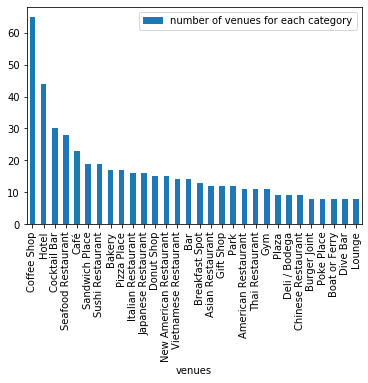

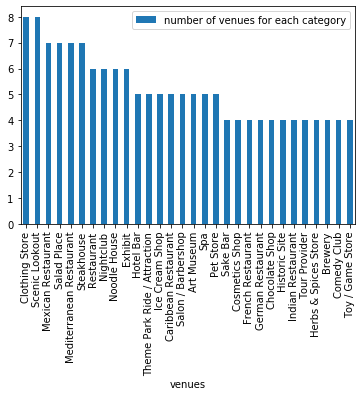

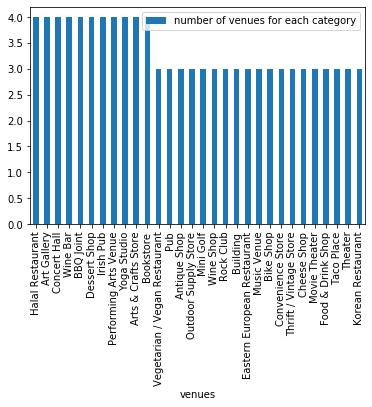

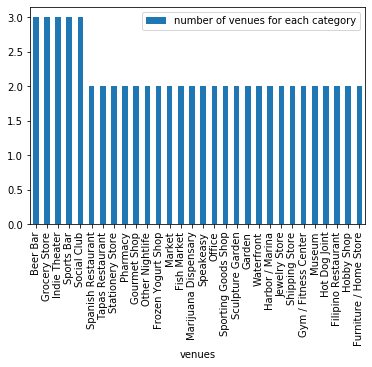

In [58]:
ven_1 = values[:30]
ven_2 = values[30:60]
ven_3 = values[60:90]
ven_4 = values[90:120]
ven_1.plot.bar(x='venues', y = 'number of venues for each category')
ven_2.plot.bar(x='venues', y = 'number of venues for each category')
ven_3.plot.bar(x='venues', y = 'number of venues for each category')
ven_4.plot.bar(x='venues', y = 'number of venues for each category')

In [57]:
fig = bar_chart_1.get_figure()
fig.savefig("bar1.png")

In [56]:
fig = bar_chart_2.get_figure()
fig.savefig("bar2.png")

In [49]:
bar_chart_3

In [50]:
bar_chart_1

In [68]:
desserts = values.iloc[[7,11,42,52,65,71,101,125]]

In [69]:
desserts

,venues,number of venues for each category
7,Bakery,17
11,Donut Shop,15
42,Ice Cream Shop,5
52,Chocolate Shop,4
65,Dessert Shop,4
71,Vegetarian / Vegan Restaurant,3
101,Frozen Yogurt Shop,2
125,Snack Place,1


In [74]:
print('The dessert venues account for {}% of the total venues'   .format(desserts['number of venues for each category'].sum()/867*100))

The dessert venues account for 5.88235294117647% of the total venues


In [75]:
neigh_venues[neigh_venues['categories'] == 'Ice Cream Shop']

,neighborhood,venue name,categories,latitude,longitude
82,Denny Triangle,Ben & Jerry’s,Ice Cream Shop,47.621472,-122.348224
317,Central Business District,Bottega Italiana,Ice Cream Shop,47.608609,-122.339733
391,Central Business District,Shug's Soda Fountain and Ice Cream,Ice Cream Shop,47.609594,-122.340624
638,International District,Shucker Muckers Ice Creamery,Ice Cream Shop,47.605904,-122.340523
801,West Edge,Bottega Italiana,Ice Cream Shop,47.608609,-122.339733


In [76]:
print('The neighboourhoods that already have stores with ice cream shops are Denny Triangle, Central Business District, International District and West Edge')

The neighboourhoods that already have stores with ice cream shops are Denny Triangle, Central Business District, International District and West Edge


In [80]:
ice = neigh_venues[neigh_venues['categories'] == 'Ice Cream Shop']
bake = neigh_venues[neigh_venues['categories'] == 'Bakery']
donut = neigh_venues[neigh_venues['categories'] == 'Donut Shop']
choc = neigh_venues[neigh_venues['categories'] == 'Chocolate Shop']
des = neigh_venues[neigh_venues['categories'] == 'Dessert Shop']
froz = neigh_venues[neigh_venues['categories'] == 'Frozen Yoghurt Shop']

In [89]:
all_desserts = pd.concat([ice,bake,donut,choc,des,froz])
all_desserts

,neighborhood,venue name,categories,latitude,longitude
82,Denny Triangle,Ben & Jerry’s,Ice Cream Shop,47.621472,-122.348224
317,Central Business District,Bottega Italiana,Ice Cream Shop,47.608609,-122.339733
391,Central Business District,Shug's Soda Fountain and Ice Cream,Ice Cream Shop,47.609594,-122.340624
638,International District,Shucker Muckers Ice Creamery,Ice Cream Shop,47.605904,-122.340523
801,West Edge,Bottega Italiana,Ice Cream Shop,47.608609,-122.339733
1,Denny Triangle,La Parisienne,Bakery,47.616911,-122.346543
83,Denny Triangle,Café An'Claire,Bakery,47.621044,-122.339832
111,Belltown,Macrina Bakery,Bakery,47.614406,-122.348155
141,Belltown,Dahlia Bakery,Bakery,47.613162,-122.340606
171,Belltown,La Parisienne,Bakery,47.616911,-122.346543


In [94]:
all_desserts.groupby('neighborhood').count()

,venue name,categories,latitude,longitude
neighborhood,,,,
Belltown,7,7,7,7
Central Business District,6,6,6,6
Central Waterfront,4,4,4,4
Denny Triangle,5,5,5,5
First Hill,3,3,3,3
International District,5,5,5,5
Pike-Market,4,4,4,4
Pioneer Square,4,4,4,4
West Edge,7,7,7,7


In [95]:
bake

,neighborhood,venue name,categories,latitude,longitude
1,Denny Triangle,La Parisienne,Bakery,47.616911,-122.346543
83,Denny Triangle,Café An'Claire,Bakery,47.621044,-122.339832
111,Belltown,Macrina Bakery,Bakery,47.614406,-122.348155
141,Belltown,Dahlia Bakery,Bakery,47.613162,-122.340606
171,Belltown,La Parisienne,Bakery,47.616911,-122.346543
174,Belltown,Piroshky Piroshky,Bakery,47.609864,-122.342440
188,Belltown,Le Panier,Bakery,47.609791,-122.342257
283,Pike-Market,Specialty’s Café & Bakery,Bakery,47.607516,-122.329292
291,Pike-Market,Grand Central Bakery,Bakery,47.600339,-122.333359
388,Central Business District,Three Girls Bakery,Bakery,47.609065,-122.340913


In [98]:
bake.groupby('neighborhood').count()

,venue name,categories,latitude,longitude
neighborhood,,,,
Belltown,5,5,5,5
Central Business District,1,1,1,1
Central Waterfront,2,2,2,2
Denny Triangle,2,2,2,2
First Hill,2,2,2,2
International District,1,1,1,1
Pike-Market,2,2,2,2
West Edge,2,2,2,2
